![img](https://blog.usetada.com/hubfs/the-value-of-loyal-customer-cover3.jpg)

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import get_dummies
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_initial = pd.read_csv('marketing_campaign..csv', sep='\t')
df_initial.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
df_initial['Dt_Customer'] = pd.to_datetime(df_initial['Dt_Customer'])

print("The oldest record on customer's enrollment:", min(df_initial['Dt_Customer']).date())
print("The newest record on customer's enrollment:", max(df_initial['Dt_Customer']).date())

The oldest record on customer's enrollment: 2012-01-08
The newest record on customer's enrollment: 2014-12-06


In [5]:
df_initial['Age'] = 2015 - df_initial['Year_Birth']
df_initial['Education'] = df_initial['Education'].replace({'Graduation': 'Graduate', 'PhD': 'Postgraduate', 'Master': 'Postgraduate', '2n Cycle': 'Postgraduate', 'Basic': 'Undergraduate'})
df_initial['Living_With'] = df_initial['Marital_Status'].replace({'Married': 'Partner', 'Together': 'Partner', 'Single': 'Alone', 'Divorced': 'Alone', 'Widow': 'Alone', 'Absurd': 'Alone', 'YOLO': 'Alone'})
df_initial['Total_Children'] = df_initial['Kidhome'] + df_initial['Teenhome']

# Breaking down the date of customer's enrollment
df_initial['Day'] = df_initial['Dt_Customer'].apply(lambda x: x.day)
df_initial['Dayofweek'] = df_initial['Dt_Customer'].apply(lambda x: x.day_name())
df_initial['Month'] = df_initial['Dt_Customer'].apply(lambda x: x.month)
df_initial['Year'] = df_initial['Dt_Customer'].apply(lambda x: x.year)

df_initial['Is_Parent'] = df_initial['Total_Children'].apply(lambda x: 1 if x != 0 else 0)
df_initial['Total_Spent'] = df_initial['MntWines'] + df_initial['MntFruits'] + df_initial['MntMeatProducts'] + df_initial['MntFishProducts'] + df_initial['MntSweetProducts'] + df_initial['MntGoldProds']

# Clear description of feature
df_initial.rename(columns={'MntWines':'Wines', 'MntFruits':'Fruits', 'MntMeatProducts':'Meats', 'MntFishProducts':'Fish', 'MntSweetProducts':'Sweets', 'MntGoldProds':'Golds'}, inplace=True)
df_initial.rename(columns={'NumWebPurchases':'Web', 'NumCatalogPurchases':'Catalog', 'NumStorePurchases':'Store'}, inplace=True)

# Drop unnecessary columns and nan values
df_initial.dropna(inplace=True)
df_initial.drop(['ID', 'Dt_Customer', 'Year_Birth', 'Marital_Status', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

df = df_initial.copy()

In [6]:
print('Income:')
print(df['Income'].sort_values().tail(5))

print('\nAge:')
print(df['Age'].sort_values().tail(5))

# Get rid of outliers
df = df.drop(2233)
df = df[df['Age'] < 80]

Income:
164     157243.0
1300    157733.0
687     160803.0
617     162397.0
2233    666666.0
Name: Income, dtype: float64

Age:
424      74
1950     75
192     115
339     116
239     122
Name: Age, dtype: int64


In [7]:
sns.color_palette('copper_r')

[(1.0, 0.6709129411764706, 0.42726470588235294),
 (0.8816606922044046, 0.5575623529411765, 0.355078431372549),
 (0.7072662695705663, 0.4472752941176471, 0.28484313725490196),
 (0.5280275574191214, 0.33392470588235296, 0.21265686274509804),
 (0.35363313478528313, 0.2236376470588235, 0.14242156862745098),
 (0.1743944226338383, 0.1102870588235294, 0.07023529411764706)]

Text(0.5, 1.05, 'Feature Relationship')

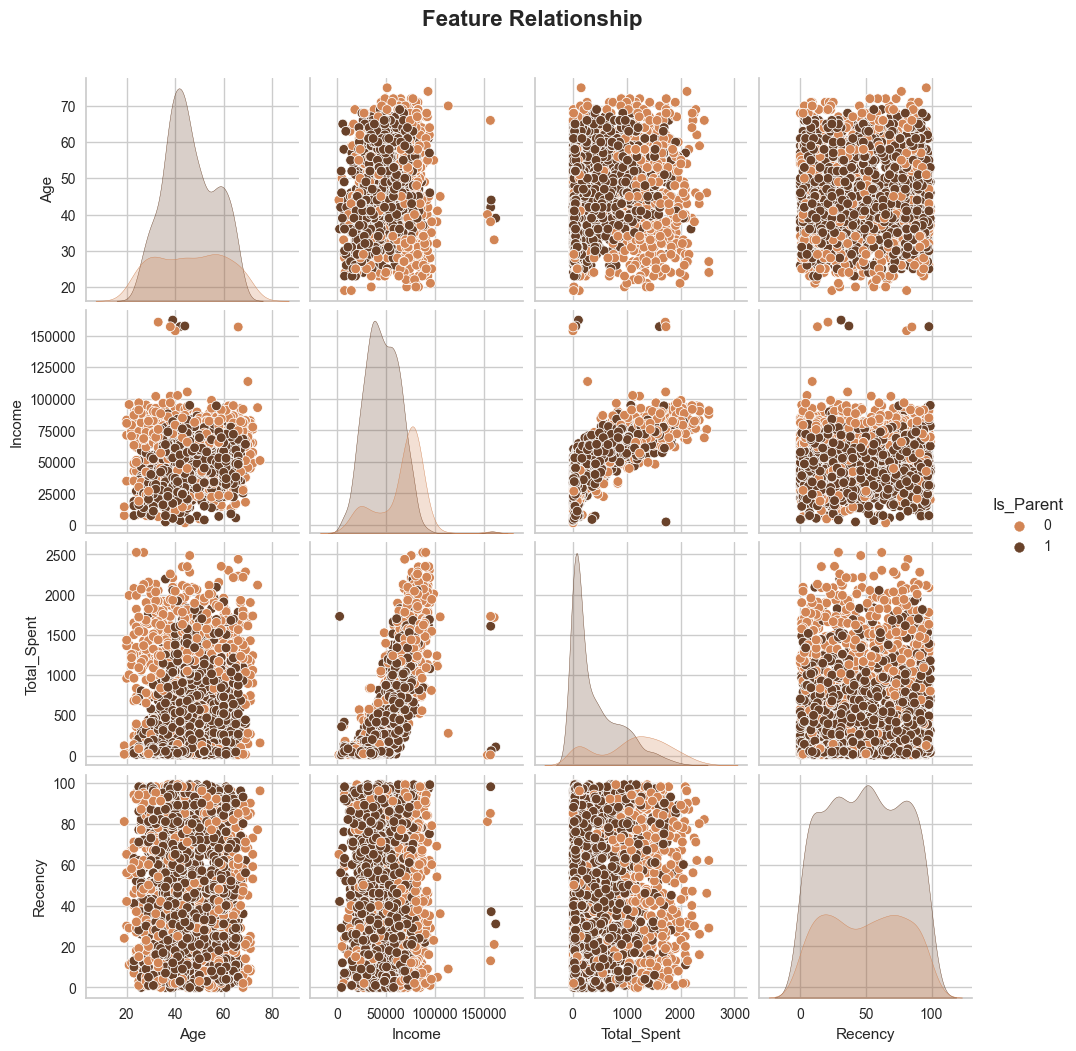

In [8]:
data = ['Age', 'Income', 'Total_Spent', 'Recency', 'Is_Parent']

plot = sns.pairplot(df[data], hue='Is_Parent', palette='copper_r')
plot.fig.suptitle('Feature Relationship', y=1.05, weight='bold', fontsize=16)

<h1><b><span style="color: #6c584c; font-size: 16px">Insights from graphs</span></b></h1>

- At a glance, we can see that parents expended less money on products than people who were not a parent yet
- People who had higher income were more likely to expend more on products

In [20]:
group = pd.cut(df['Age'], [10, 20, 30, 40, 50, 60, 70, 80])
group.value_counts()

(40, 50]    669
(30, 40]    552
(50, 60]    459
(60, 70]    298
(20, 30]    212
(70, 80]     15
(10, 20]      7
Name: Age, dtype: int64

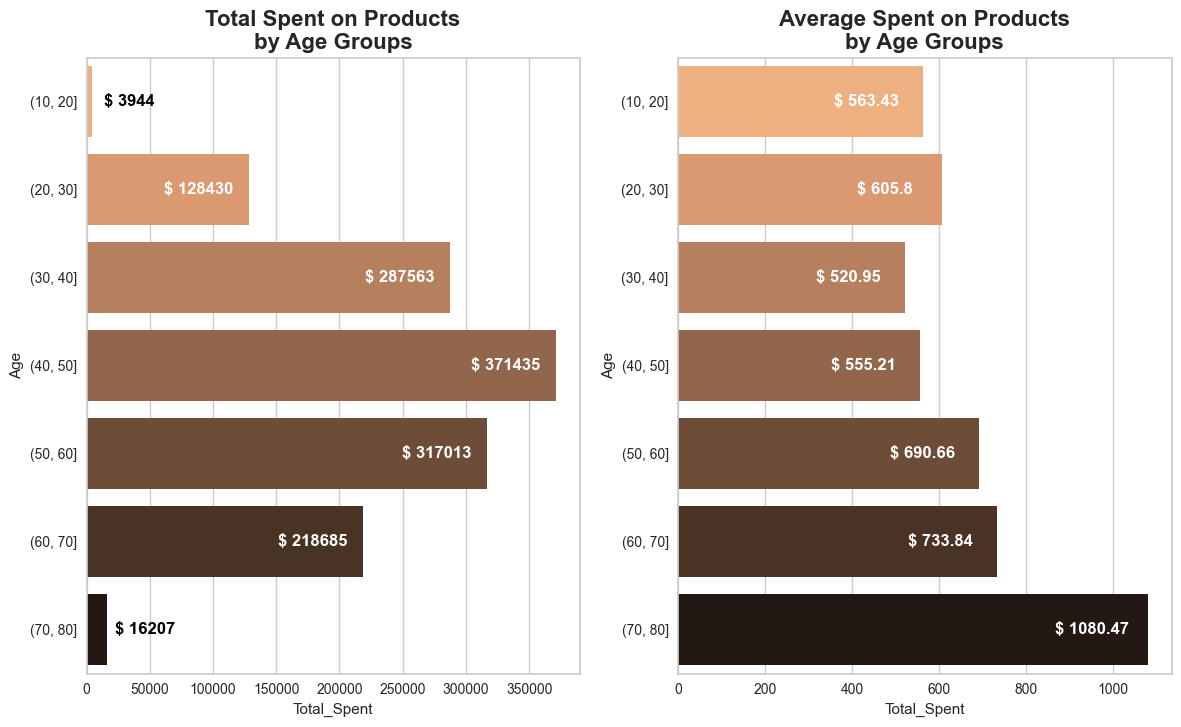

In [21]:
df2 = df.copy()
df2['Age'] = group

sum_group = df2[['Total_Spent', 'Age']].groupby('Age').sum()
mean_group = df2[['Total_Spent', 'Age']].groupby('Age').mean()

fig, axes = plt.subplots(1,2,figsize=(14,8))
axes = axes.flatten()

sns.barplot(x=sum_group['Total_Spent'], y=sum_group.index, palette='copper_r', ci=None, orient='h', ax=axes[0])
axes[0].set_title('Total Spent on Products\nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(sum_group['Total_Spent']):
    if i == 0 or i ==6:
        axes[0].text(v+30000, i, '$ {}'.format(v), horizontalalignment='center', verticalalignment='center', weight='bold', color='black', fontsize=12)
    else:
        axes[0].text(v-40000, i, '$ {}'.format(v), horizontalalignment='center', verticalalignment='center', weight='bold', color='white', fontsize=12)

sns.barplot(x=mean_group['Total_Spent'], y=mean_group.index, palette='copper_r', ci=None, orient='h', ax=axes[1])
axes[1].set_title('Average Spent on Products\nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(mean_group['Total_Spent']):
    axes[1].text(v-130, i, '$ {}'.format(round(v,2)), horizontalalignment='center', verticalalignment='center', weight='bold', color='white', fontsize=12)

### Insights from graphs
- The distribution of the data was not equal for each group. There was only 21 people in total of the first group and the last group. That's why there was a huge contrast on total spent

- Since the number of people in each group was not balanced, we can use average spent. People over 70 years old spent more money on products compared to the rest of the age group with more than 1000 dollars, It's 2 times higher than 30-40 years people did in the same period of time

(0.0, 1.0, 0.0, 1.0)

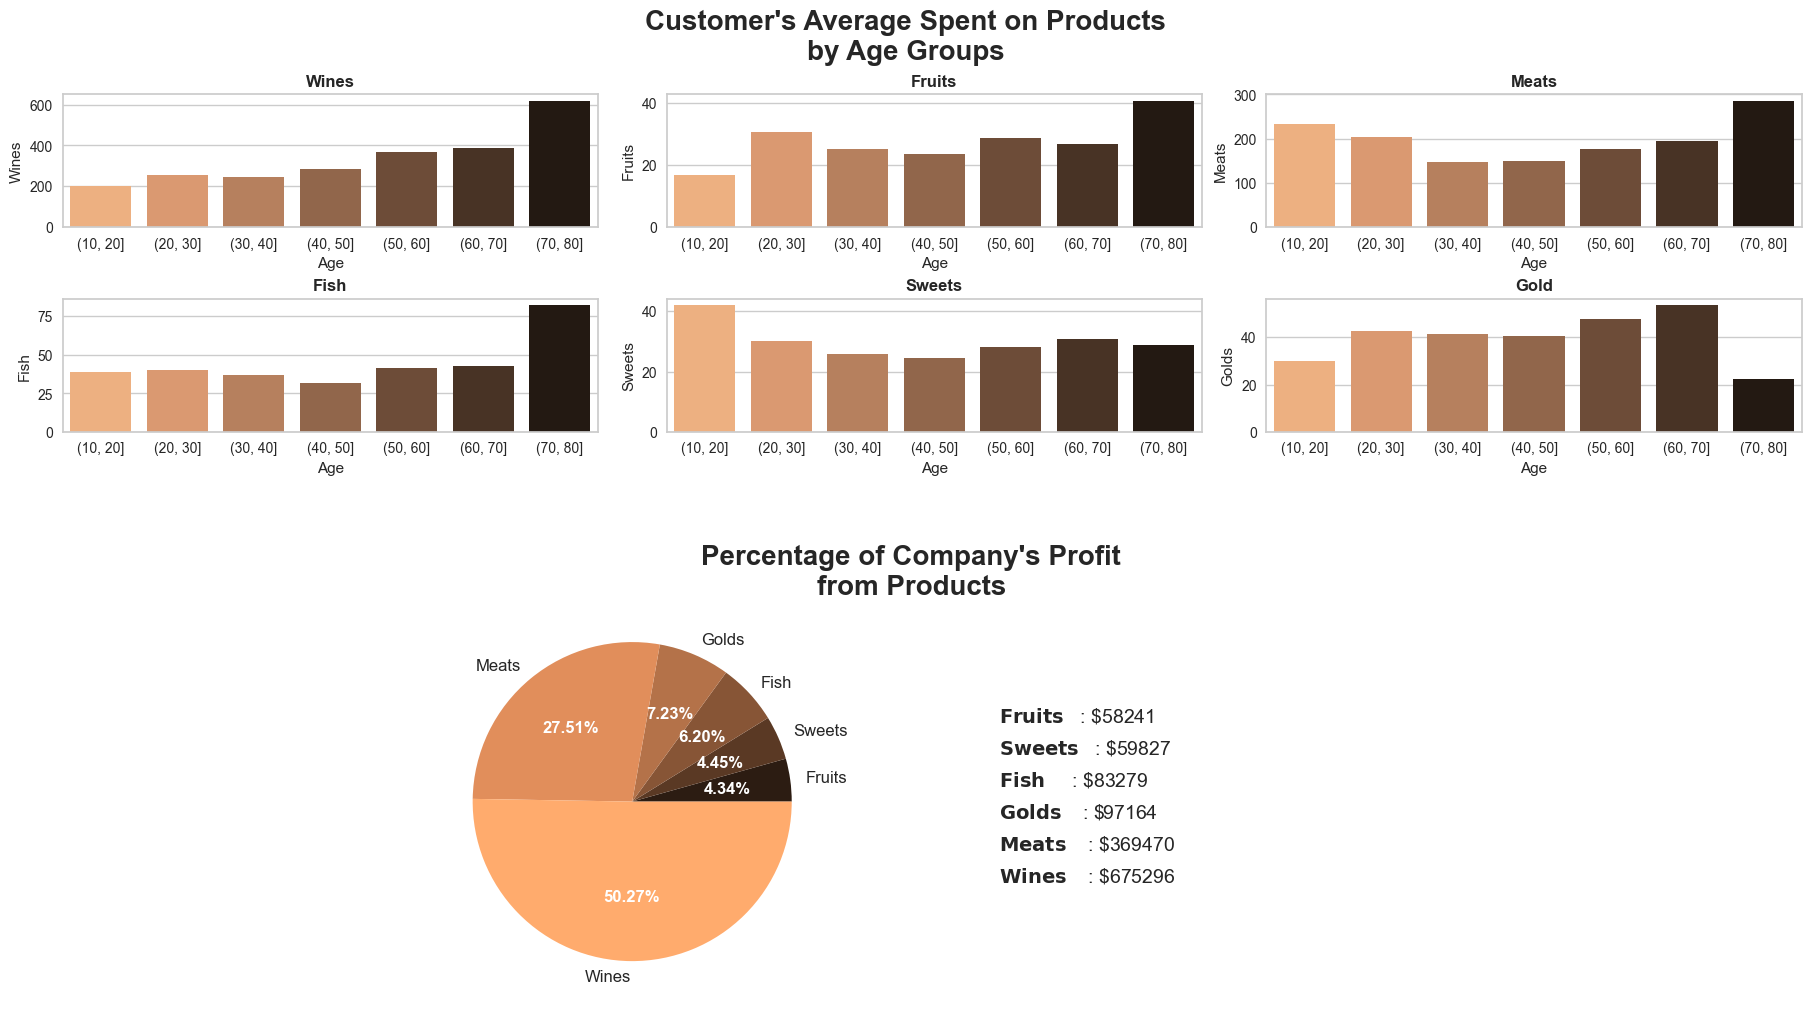

In [23]:
fig, axd = plt.subplot_mosaic([[0,1,2],[3,4,5], [6,6,7], [6,6,7], [6,6,7]],
                              constrained_layout=True, figsize=(18,10))

fig.suptitle("Customer's Average Spent on Products\nby Age Groups", weight='bold', fontsize=20)

# Bar plot
sns.barplot(data=df, x=group, y='Wines', palette='copper_r', ci=None, ax=axd[0])
axd[0].set_title('Wines', weight='bold')
sns.barplot(data=df, x=group, y='Fruits', palette='copper_r', ci=None, ax=axd[1])
axd[1].set_title('Fruits', weight='bold')
sns.barplot(data=df, x=group, y='Meats', palette='copper_r', ci=None, ax=axd[2])
axd[2].set_title('Meats', weight='bold')
sns.barplot(data=df, x=group, y='Fish', palette='copper_r', ci=None, ax=axd[3])
axd[3].set_title('Fish', weight='bold')
sns.barplot(data=df, x=group, y='Sweets', palette='copper_r', ci=None, ax=axd[4])
axd[4].set_title('Sweets', weight='bold')
sns.barplot(data=df, x=group, y='Golds', palette='copper_r', ci=None, ax=axd[5])
axd[5].set_title('Gold', weight='bold')

# Pie chart
data = df[['Wines', 'Fruits', 'Meats', 'Fish', 'Sweets', 'Golds']].sum().sort_values()

palette = sns.color_palette('copper')
wedges, texts, autotexts = axd[6].pie(x=data, labels=data.index, autopct='%.2f%%', colors=palette, textprops=dict(fontsize=12));
axd[6].set_title("\n\nPercentage of Company's Profit\nfrom Products", weight='bold', fontsize=20, x=1.2)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

# Text
for i, (name, value) in enumerate(zip(data.index, data)):
    axd[6].text(2.3, 0.5-0.2*i, r"$\bf{" + name + "}$" + "\t:" + " \$" + str(value), fontsize=14)

axd[7].axis('off')

<h1><b><span style="color: #6c584c; font-size: 16px">Insights from graphs</span></b></h1>

- All the products were dominated by people over 70 years old except for the sweets and golds
- The oldest group's average spent on wines was incredibly high above 600 dollars
- Wines were the company's best selling product followed by meats, and golds. For wine products only, it yielded more than 675k dollars in a span of 3 years. It's 50.27% of company's income

(0.0, 1.0, 0.0, 1.0)

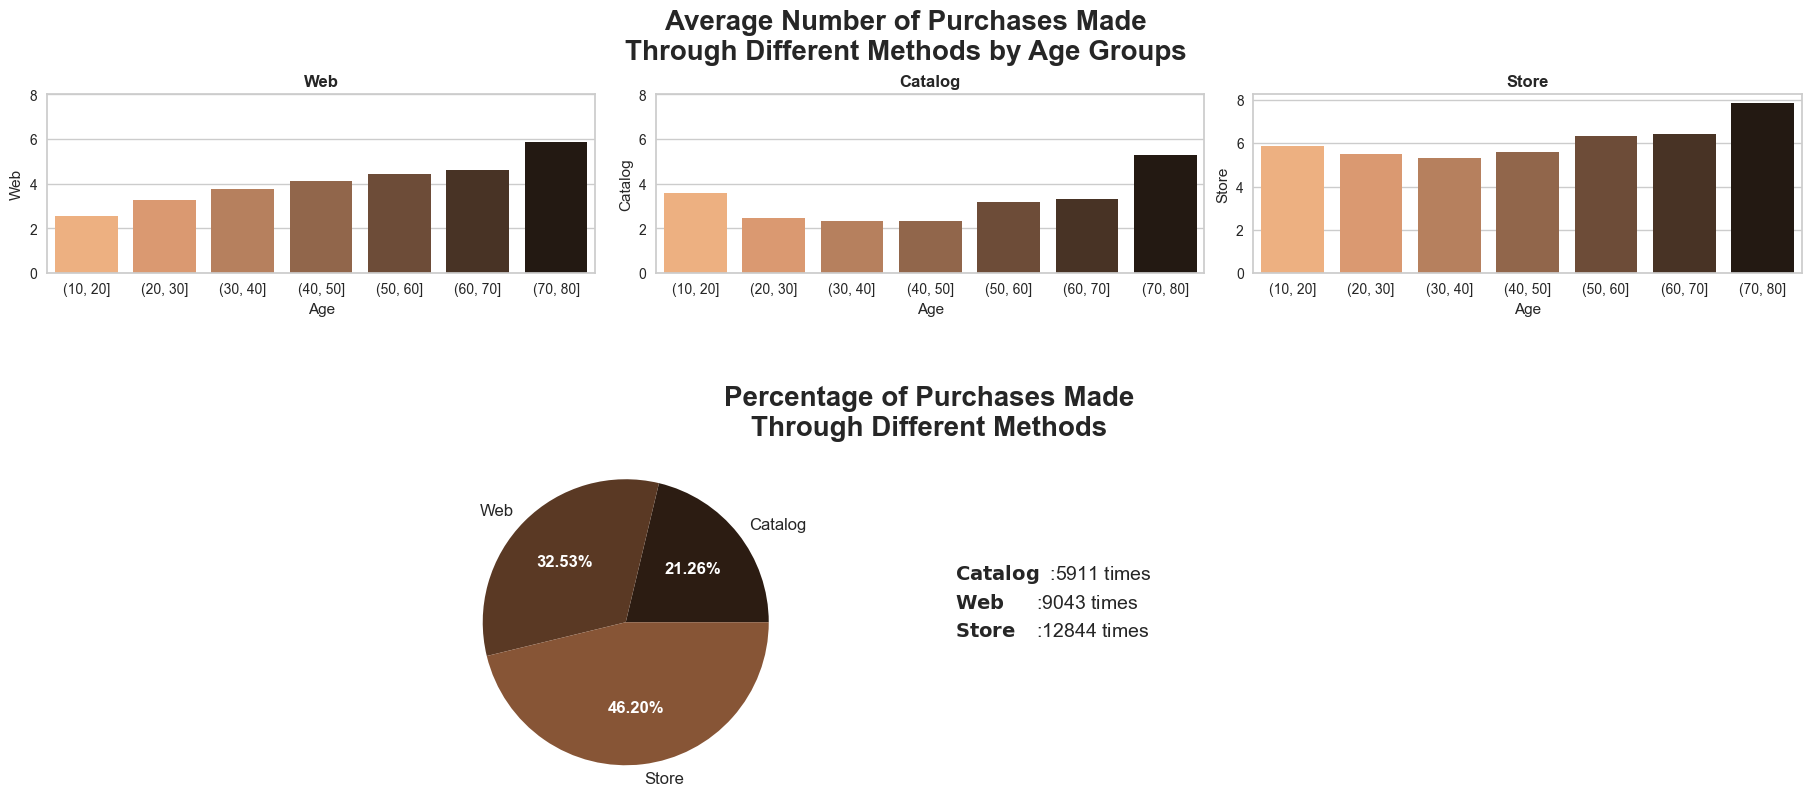

In [25]:
fig, axd = plt.subplot_mosaic([[0,1,2], [3,3,4], [3,3,4]],
                               constrained_layout=True, figsize=(18,8))
fig.suptitle("Average Number of Purchases Made\nThrough Different Methods by Age Groups", weight='bold', fontsize=20)

custom_ylim = (0, 8)
plt.setp(axd[0], ylim=custom_ylim)
plt.setp(axd[1], ylim=custom_ylim)

# Bar plot
sns.barplot(data=df, x=group, y='Web', palette='copper_r', ci=None, ax=axd[0])
axd[0].set_title('Web', weight='bold')
sns.barplot(data=df, x=group, y='Catalog', palette='copper_r', ci=None, ax=axd[1])
axd[1].set_title('Catalog', weight='bold')
sns.barplot(data=df, x=group, y='Store', palette='copper_r', ci=None, ax=axd[2])
axd[2].set_title('Store', weight='bold')

# Pie chart
data = df[['Web', 'Catalog', 'Store']].sum().sort_values()

palette = sns.color_palette('copper')
wedges, texts, autotexts = axd[3].pie(x=data, labels=data.index, autopct='%.2f%%', colors=palette, textprops=dict(fontsize=12));
axd[3].set_title('\n\nPercentage of Purchases Made\nThrough Different Methods', weight='bold', fontsize=20, x=1.35)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

# Text
for i, (name, value) in enumerate(zip(data.index, data)):
    axd[3].text(2.3, 0.3-0.2*i, r"$\bf{" + name + "}$" + "\t:" + str(value) + " times", fontsize=14)

axd[4].axis('off')

<h1><b><span style="color: #6c584c; font-size: 16px">Insights from graphs</span></b></h1>

- Purchases made through web, catalog, and store were also dominated by people over 70 years old even though the number of people in that age group were only 15 (look at the number of people of each group). It's because the number of purchases they made were higher than the rest of age groups
- A large number of successful purchases occurred directly in the store. It accounted for 46.2% of total purchases made to the company

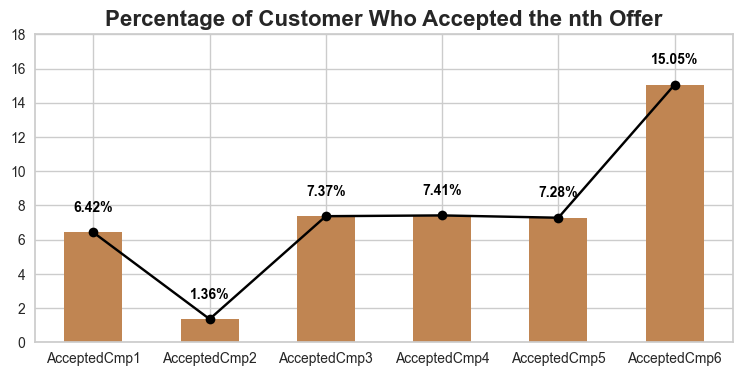

In [27]:
df.rename(columns={'Response':'AcceptedCmp6'}, inplace=True)

plt.figure(figsize=(9,4))
plt.title('Percentage of Customer Who Accepted the nth Offer', weight='bold', fontsize=16)

percent = df.sum()[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp6']]*100/len(df)

ax = percent.plot.bar(color='#c08552')
percent.plot(style='o-', colormap='copper')

plt.setp(ax, ylim=(0, 18))

for i,v in enumerate(percent):
    plt.text(i, v+1.2, '{:.2f}%'.format(v), horizontalalignment='center', weight='bold', color='Black', fontsize=10)

<h1><b><span style="color: #6c584c; font-size: 16px">Insights from graphs</span></b></h1>

- The percentage of people who directly accepted the offer in the first campaign were just 6.42%. The number became even smaller in the second campaign with just 1.36% of the customers
- The last campaign successfully drew the most customers compared to the previous campaigns with 15.05% percentage of customers.  

<Axes: title={'center': 'Average Number of Purchases Made with a Discount\nby Age Groups'}, xlabel='Age', ylabel='NumDealsPurchases'>

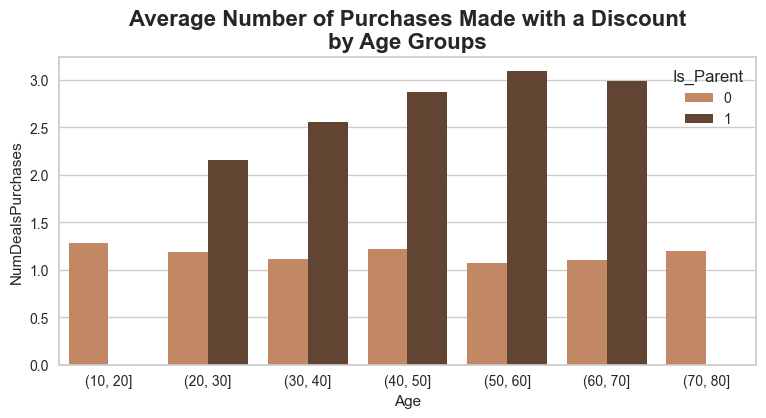

In [29]:
plt.figure(figsize=(9,4))
plt.title('Average Number of Purchases Made with a Discount\nby Age Groups', weight='bold', fontsize=16)
sns.barplot(data=df, x=group, y='NumDealsPurchases', hue='Is_Parent', ci=None, palette='copper_r')

<h1><b><span style="color: #6c584c; font-size: 16px">Insights from graphs</span></b></h1>

- Parents were the ones who were attracted more easily by discounts. It's clearly shown on the graph above where in this case the number of purchases made with a discount by parents surpassed non-parents

<Axes: title={'center': 'Feature correlation'}>

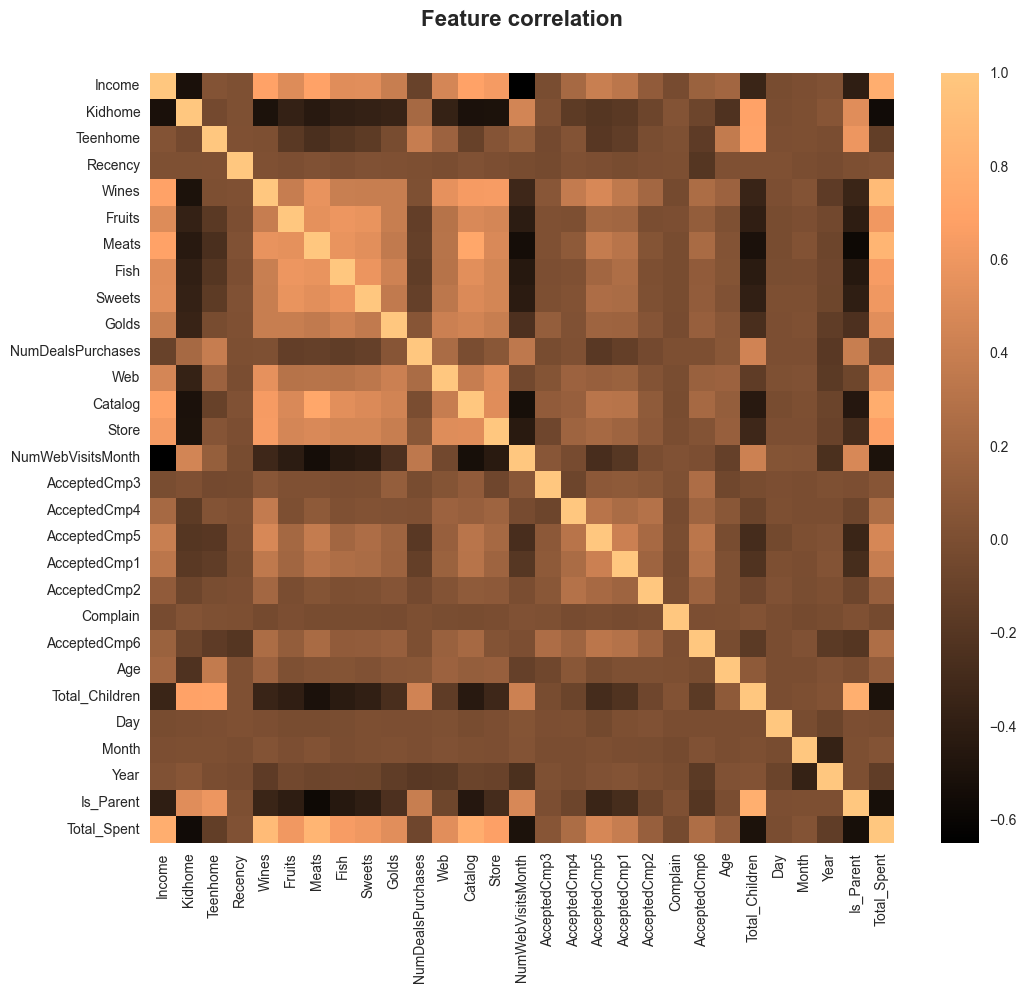

In [31]:
data = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12,10))
plt.title('Feature correlation', weight='bold', fontsize=16, y=1.05)
sns.heatmap(df[data].corr(), cmap='copper')

<h1><b><span style="color: #6c584c; font-size: 16px">Insights from graphs</span></b></h1>

- Apparently, total children and parenthood status have minor correlation on customer's total spent
- As we expected, income and all products are the features that influence total spent the most